# FCN-VGG16

In [1]:
import sys
from time import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.append("..")
from dataset import Pipeline, DatasetIndex, Dataset

from fcn import FCNModel                                        # TFModel subclass with LinkNet
from task_02.nmnist import NoisedMnist                                          # Batch subclass with loading and noise actions
from task_02.plot_functions import plot_noised_image, plot_examples_highlighted # plot functions to demonstrate result 

Fix constants to generate noised images and train LinkNet:

In [2]:
IMAGE_SIZE = 128     # image size
MNIST_SIZE = 1000   # MNIST database size
BATCH_SIZE = 20     # batch size for NN training
MAX_ITER = 5       # number of iterations for NN training

Define noise parameters:

In [3]:
level = 1           # the highest level of noise; [0, 1]
n_fragments = 60    # number of noise fragments per image  
size = 8            # size of noise fragment; 1, ..., 27
distr = 'normal'    # distribution of fragments of image; 'uniform' or 'normal'

Create DatasetIndex and Dataset to use pipelines:

In [4]:
ind = DatasetIndex(np.arange(MNIST_SIZE))          # index for images
mnistset = Dataset(ind, batch_class=NoisedMnist)   # Dataset with transform actions in NoisedMnist class
mnistset.cv_split([0.9, 0.1])                      # divide it into train and test

Сreate Pipeline template for image loading and transformation. The first parameter of create_noise is the type of noise: 'mnist_noise' - MNIST-based noise, 'random_noise' - uniform random noise.

In [5]:
load_template = (Pipeline()
                 .load_images()                    # load MNIST images from file
                 .random_location(IMAGE_SIZE)      # put MNIST at random location
                 .create_mask()                    # create mask for MNIST image location
                 .create_noise('mnist_noise',
                            level,
                            n_fragments, 
                            size, 
                            distr))

Plot example of noised images (train images are greyscale but we highlight true digit in yellow to plot):

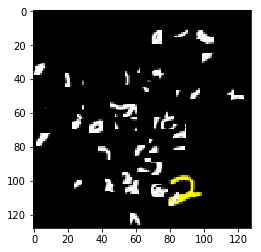

In [6]:
images = []
noise = []
(load_template << mnistset.train).get_images(images).get_noise(noise).next_batch(10, shuffle=True)
plot_noised_image(images[0][0], noise[0][0])

Create feed_dict's for TFModel. 
* '<b>input_image</b>' - name of input placeholdes described in TFModel
* '<b>images</b>' - name of attribute in NoisedMnist class
* '<b>targets</b>' - name of target placeholdes described in TFModel
* '<b>masks</b>' - name of attribute in NoisedMnist class
* '<b>bn_mode</b>' - name of placeholdes for batch normalization training parameter 

In [7]:
train_feed_dict = {'input_image': 'images',
                   'targets': 'masks',
                   'bn_mode': True}        

test_feed_dict = {'input_image': 'images',
                  'targets': 'masks',
                  'bn_mode': False}

Create train and test pipelines:

In [ ]:
ppl_train = ((load_template << mnistset.train)
            .add_noise()
            .init_variable('train_loss_history', init_on_each_run=list)
            .init_model('static',                                          # model mode
                        FCNModel,                                      # TFModel subclass with LinkNet
                        'FCN',                                         # model name
                        config={'loss': 'softmax_cross_entropy',
                                'optimizer': 'Adam',
                                'n_classes': 2,
                                'images_shape': (IMAGE_SIZE, IMAGE_SIZE)})
            .train_model('FCN',                                        # model name
                         fetches='loss',                                   # tensors to get value 
                         feed_dict=train_feed_dict,                        
                         append_to='train_loss_history'))                  # name of pipeline variable to save loss value

ppl_test = ((load_template << mnistset.test)
            .add_noise()
            .import_model('FCN', ppl_train)
            .init_variable('test_loss_history', init_on_each_run=list)
            .predict_model('FCN', 
                           fetches='loss',
                           feed_dict=test_feed_dict,
                           append_to='test_loss_history'))

Tensor("FCN-conv/VGG-conv/conv-block-last-4/max_pooling2d/MaxPool:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("FCN-conv/conv-out-3/Relu:0", shape=(?, 4, 4, 2), dtype=float32)
Tensor("FCN-conv/conv2d_transpose/BiasAdd:0", shape=(?, 128, 128, 2), dtype=float32)


Train LinkNet on noised data:

In [ ]:
# training of the model

start = time()

for i in range(MAX_ITER):
    ppl_train.next_batch(BATCH_SIZE, n_epochs=None)                              # training step
    ppl_test.next_batch(100, n_epochs=None)                                      # compute test loss
    
    train_loss = ppl_train.get_variable('train_loss_history')[-1]                # get current iteration train loss
    test_loss = ppl_test.get_variable('test_loss_history')[-1]                   # get current iteration test loss
    
    if (i+1) % 1 == 0:
        print("Iter {:3d}: train {:05.3f} test {:05.3f}".format(i+1, train_loss, test_loss))
        
stop = time()

print("Train time: {:05.3f} min".format((stop-start)/60))

Plot train and test loss:

In [ ]:
plt.plot(ppl_train.get_variable('train_loss_history'), label='Train loss')
plt.plot(ppl_train.get_variable('test_loss_history'), label='Test loss')
plt.legend()
plt.show()

Create pipeline to get some images from test dataset and corresponding masks, noise and mask predictions:

In [ ]:
images = []
masks = []
noise = []

ppl_plot = ((load_template << mnistset.test)                       # load data from file
             .get_images(images)                                   # images without noise
             .get_masks(masks)                                     # get masks
             .get_noise(noise)                                     # get noise
             .add_noise()                                          # add noise to images
             .import_model('linknet', ppl_train)
             .init_variable('predictions', init_on_each_run=list)
             .predict_model('linknet',                                      
                           fetches='predicted_prob',
                           feed_dict=test_feed_dict,
                           append_to='predictions'))

Get predictions for 10 images:

In [ ]:
ppl_plot.next_batch(10, n_epochs=None)
predictions = ppl_plot.get_variable('predictions')[-1]

Plot images with highlighted digit, mask for $28 \times 28$ image, binary mask prediction and probability prediction:

In [ ]:
plot_examples_highlighted(images, noise, masks, predictions)